In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylab import subplot,imshow,title,gray,NullLocator
import scipy.misc as mi
import scipy.special as sp
from PIL import Image
from itertools import chain
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.models import model_from_json

from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
#K.set_image_dim_ordering('th')

In [5]:
keras.backend.backend()

'theano'

In [7]:
#keras.backend.image_dim_ordering()

In [8]:
# visualizza dati
def displayData(X, t, rows=10, cols=10, img_ind=None, size =16, class_value = False):
    if len(X)>rows*cols:
        img_ind = np.random.permutation(len(X))[0:rows * cols]
    else:
        img_ind = range(rows*cols)
    fig = plt.figure(figsize = (size,size))
    fig.patch.set_facecolor('white')
    ax = fig.gca()
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow([255-x for x in X[img_ind[i]]], cmap='gray', interpolation='gaussian')
        if class_value:
            plt.title("{}".format(t[img_ind[i]]),fontsize = 16, color='b')
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.axis('off')
    plt.subplots_adjust(top=1)
    plt.show()

In [9]:
def plotData(X, Y, c, npixel=28):
    m, n = X.shape
    image = np.array(X[c,:])
    plt.figure(figsize = (6,6))
    plt.imshow((image.reshape(npixel, npixel)), cmap='Greys', interpolation='quadric')
    plt.show()

In [10]:
def plotAccuracy(acc_history_train, acc_history_test):
    plt.figure(figsize = (12,8))
    plt.plot(acc_history_train, marker='o', markersize=5, label='Train')
    plt.plot(acc_history_test, marker='o', markersize=5, label='Test')
    plt.legend()
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.show()

In [11]:
def save_model(m,filename):
    model_json = m.to_json()
    with open(filename+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    m.save_weights(filename+".h5")
    print("Saved model to disk")

In [12]:
def load_model(filename):
    json_file = open(filename+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    m = model_from_json(loaded_model_json)
    # load weights into new model
    m.load_weights(filename+".h5")
    print("Loaded model from disk")
    return m

In [46]:
def load_model_weights(filename, model):
    model.load_weights(filename+".h5")
    print("Loaded weights from disk")
    return model

Fissa il numero di classi pari a 10 (corrispondenti alle cifre 0,1,...,9) e leggi i dati, suddivisi in training e test set, $(X_{train}, t_{train}), (X_{test}, t_{test})$. Le matrici $X$ rappresentano le immagini, mentre i vettori $t$ specificano le relative classi.

In [13]:
nb_classes = 10

(X_train, t_train), (X_test, t_test) = mnist.load_data()

In [14]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

Visualizza la dimensione di $X_{train}$ e $X_{test}$. Le immagini rappresentate risultano indicizzate dalla prima dimensione e definite come matrici $28\times 28$. I valori nelle matrici sono interi compresi tra $0$ e $255$.


In [15]:
X_train[0,:,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

Esempio: i primi 100 elementi nel training set con la relativa classe

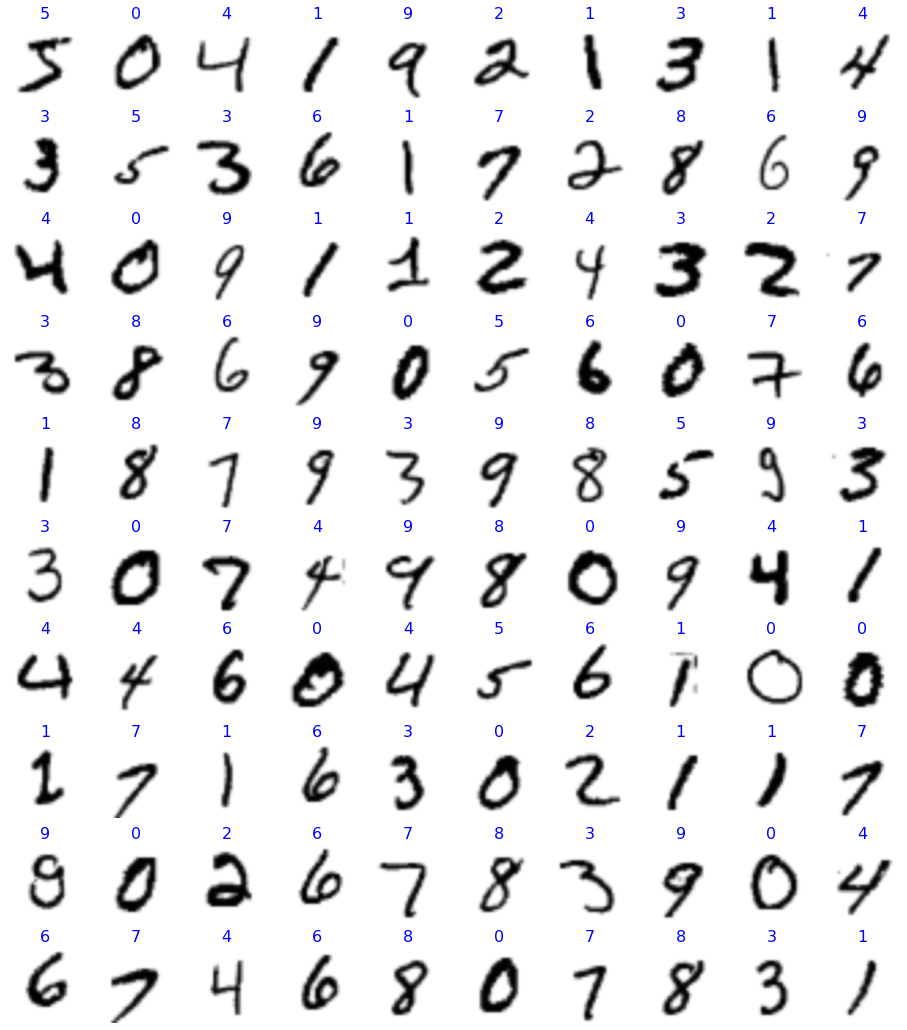

In [16]:
displayData(X_train[0:100], t_train[0:100], class_value=True)

Modifica la rappresentazione degli elementi da matrici $28\times 28$ a vettori di dimensione $784$, con elementi reali compresi tra $0$ e $1$.

In [17]:
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [18]:
X_train[0,:].shape

(784,)

Le classi vengono codificate nella forma $\textit{one-hot}$, come vettori di dimensione $10$ (il numero delle classi) con elementi pari a $0$, eccetto quello di indice pari al valore da codificare.


In [19]:
T_train = np_utils.to_categorical(t_train, nb_classes)
T_test = np_utils.to_categorical(t_test, nb_classes)

In [20]:
t_train[0:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [21]:
T_train[0:5,:]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

Costruisci il modello (insieme delle possibili funzioni)

In [22]:
# softmax regression
model0 = Sequential()
model0.add(Dense(10, input_shape=(784,)))
model0.add(Activation('softmax'))
model0.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='sgd')

In [47]:
#model0 = load_model_weights('softmax', model0)

Loaded weights from disk


Cerca la migliore funzione possibile, rispetto ai dati disponibili

In [23]:
history0 = model0.fit(X_train, T_train, batch_size=512, epochs=50, verbose=1, validation_data=(X_test, T_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 22us/step - loss: 1.8339 - accuracy: 0.4982 - val_loss: 1.4595 - val_accuracy: 0.6923
Epoch 2/50
60000/60000 [==============================] - 0s 6us/step - loss: 1.2824 - accuracy: 0.7333 - val_loss: 1.1002 - val_accuracy: 0.7815
Epoch 3/50
60000/60000 [==============================] - 0s 7us/step - loss: 1.0261 - accuracy: 0.7883 - val_loss: 0.9151 - val_accuracy: 0.8150
Epoch 4/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.8832 - accuracy: 0.8144 - val_loss: 0.8038 - val_accuracy: 0.8316
Epoch 5/50
60000/60000 [==============================] - 0s 8us/step - loss: 0.7924 - accuracy: 0.8283 - val_loss: 0.7294 - val_accuracy: 0.8431
Epoch 6/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.7291 - accuracy: 0.8379 - val_loss: 0.6761 - val_accuracy: 0.8515
Epoch 7/50
60000/60000 [==============================] - 0s 7us/step - l

In [21]:
save_model(model0,'softmax')

Saved model to disk


Accuracy: frazione di risposte corrette

In [29]:
acc_values0 = history0.history['accuracy']
val_acc_values0 = history0.history['val_accuracy']

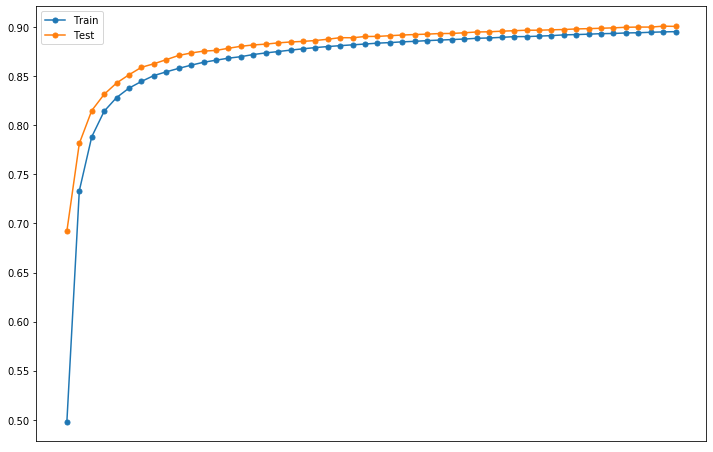

In [30]:
plotAccuracy(acc_values0, val_acc_values0)

In [31]:
predictions_train = model0.predict_classes(X_train, verbose=0)

In [32]:
confusion_matrix(t_train, predictions_train)

array([[5677,    0,   26,   19,   13,   47,   55,    7,   70,    9],
       [   0, 6499,   34,   35,    5,   54,    8,   14,   83,   10],
       [  58,   79, 5118,   95,  125,   15,  121,  126,  176,   45],
       [  31,   39,  148, 5310,    6,  258,   44,   79,  134,   82],
       [  12,   34,   51,    5, 5308,    6,   66,   14,   50,  296],
       [ 101,   69,   45,  231,   86, 4427,  114,   32,  222,   94],
       [  43,   25,   61,    7,   47,   88, 5586,    2,   57,    2],
       [  46,   89,  101,   20,   90,    9,    3, 5656,   23,  228],
       [  33,  177,   87,  175,   26,  182,   55,   37, 4964,  115],
       [  46,   42,   40,  100,  217,   41,    5,  208,   53, 5197]])

Accuracy is the fraction of items well classified wrt all items

In [33]:
accuracy_score(t_train, predictions_train)

0.8957

Precision of class $C_i$: number of items of class $C_i$ well classified divided by number of items classified as belonging to $C_i$

Recall of class $C_i$: number of items of class $C_i$ well classified divided by number of items belonging to $C_i$

F-measure of class $C_i$: harmonic mean of precision and recall for class $C_i$

In [34]:
meas = precision_recall_fscore_support(t_train, predictions_train, average=None)
print('Training set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Training set
Class 0: precision= 0.96, recall= 0.95, f-measure= 0.95
Class 1: precision= 0.96, recall= 0.94, f-measure= 0.94
Class 2: precision= 0.86, recall= 0.88, f-measure= 0.88
Class 3: precision= 0.87, recall= 0.88, f-measure= 0.88
Class 4: precision= 0.91, recall= 0.90, f-measure= 0.90
Class 5: precision= 0.82, recall= 0.84, f-measure= 0.84
Class 6: precision= 0.94, recall= 0.93, f-measure= 0.93
Class 7: precision= 0.90, recall= 0.91, f-measure= 0.91
Class 8: precision= 0.85, recall= 0.85, f-measure= 0.85
Class 9: precision= 0.87, recall= 0.86, f-measure= 0.86


In [35]:
predictions_test = model0.predict_classes(X_test, verbose=0)

In [36]:
confusion_matrix(t_test, predictions_test)

array([[ 957,    0,    2,    2,    1,    2,    9,    1,    6,    0],
       [   0, 1099,    2,    4,    1,    3,    4,    0,   22,    0],
       [  12,    7,  887,   17,   17,    1,   15,   23,   44,    9],
       [   5,    1,   19,  896,    1,   36,    5,   16,   19,   12],
       [   1,    4,    4,    1,  902,    0,   13,    2,    8,   47],
       [  15,    6,    7,   45,   15,  733,   16,    7,   36,   12],
       [  16,    3,    4,    3,   13,   16,  896,    1,    6,    0],
       [   2,   18,   27,    5,   12,    0,    0,  921,    4,   39],
       [  10,   10,   11,   29,   13,   26,   13,   15,  833,   14],
       [  11,    8,    7,   10,   40,   14,    0,   27,    8,  884]])

In [37]:
accuracy_score(t_test, predictions_test)

0.9008

In [38]:
meas = precision_recall_fscore_support(t_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 0.98, recall= 0.95, f-measure= 0.95
Class 1: precision= 0.97, recall= 0.96, f-measure= 0.96
Class 2: precision= 0.86, recall= 0.89, f-measure= 0.89
Class 3: precision= 0.89, recall= 0.89, f-measure= 0.89
Class 4: precision= 0.92, recall= 0.90, f-measure= 0.90
Class 5: precision= 0.82, recall= 0.85, f-measure= 0.85
Class 6: precision= 0.94, recall= 0.93, f-measure= 0.93
Class 7: precision= 0.90, recall= 0.90, f-measure= 0.90
Class 8: precision= 0.86, recall= 0.85, f-measure= 0.85
Class 9: precision= 0.88, recall= 0.87, f-measure= 0.87


In [39]:
w0 = model0.layers[0].get_weights()
w = w0[0]

In [40]:
w0[1]

array([-0.11904064,  0.21271725, -0.03324383, -0.08544941,  0.07826184,
        0.28691995, -0.03386725,  0.17093432, -0.40305147, -0.07418104],
      dtype=float32)

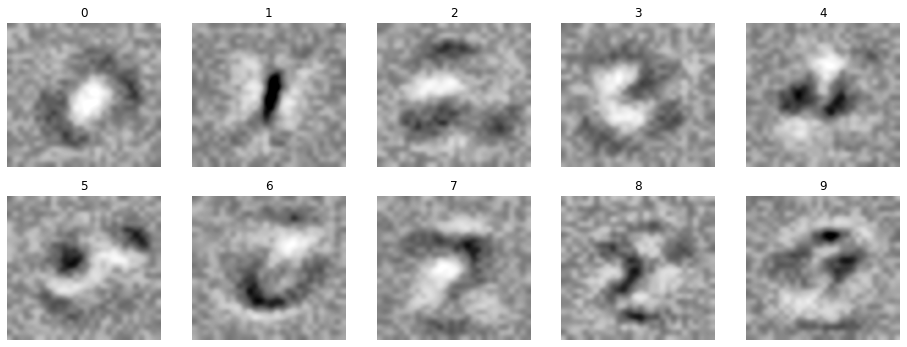

In [41]:
fig = plt.figure(figsize=(16,16))
fig.patch.set_facecolor('white')
for i in range(10):
    ax = subplot(2,5,i+1,frame_on=False, facecolor="#F8F8F8")
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    imshow(w[:,i].reshape(28,28), interpolation='quadric', 
           cmap=plt.get_cmap('Greys'), vmin=np.mean(w[:,i])-3.5*np.std(w[:,i]), 
           vmax=np.mean(w[:,i])+3.5*np.std(w[:,i]), aspect='auto')
    plt.title(i)
plt.subplots_adjust(top=0.4)
plt.show()

Elemento 8331


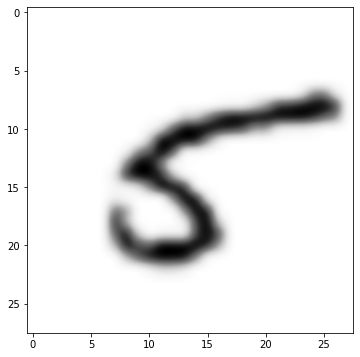

Un 5, classificato come 5


In [42]:
c = np.random.randint(0, X_test.shape[0])
p=model0.predict_classes(X_test[c:c+1,:], verbose=0)
print("Elemento "+str(c))
plotData(X_test, t_test, c)
print("Un "+str(t_test[c])+", classificato come " + str(p[0]))

In [43]:
# 3 layer NN
model1 = Sequential()
model1.add(Dense(512, input_shape=(784,)))
model1.add(Activation('relu'))
model1.add(Dropout(rate=0.2))
model1.add(Dense(10))
model1.add(Activation('softmax'))
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [44]:
history1 = model1.fit(X_train, T_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test, T_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 155us/step - loss: 0.5838 - accuracy: 0.8375 - val_loss: 0.2607 - val_accuracy: 0.9254
Epoch 2/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.2462 - accuracy: 0.9298 - val_loss: 0.1943 - val_accuracy: 0.9450
Epoch 3/10
60000/60000 [==============================] - 9s 158us/step - loss: 0.1858 - accuracy: 0.9476 - val_loss: 0.1562 - val_accuracy: 0.9548
Epoch 4/10
60000/60000 [==============================] - 11s 184us/step - loss: 0.1499 - accuracy: 0.9575 - val_loss: 0.1325 - val_accuracy: 0.9619
Epoch 5/10
60000/60000 [==============================] - 11s 184us/step - loss: 0.1247 - accuracy: 0.9648 - val_loss: 0.1153 - val_accuracy: 0.9668
Epoch 6/10
60000/60000 [==============================] - 11s 187us/step - loss: 0.1066 - accuracy: 0.9699 - val_loss: 0.1035 - val_accuracy: 0.9693
Epoch 7/10
60000/60000 [==============================] - 7

In [39]:
save_model(model1,'3MLP')

Saved model to disk


In [40]:
acc_values1 = history1.history['acc']
val_acc_values1 = history1.history['val_acc']

epochs1 = range(1, len(acc_values1) + 1)

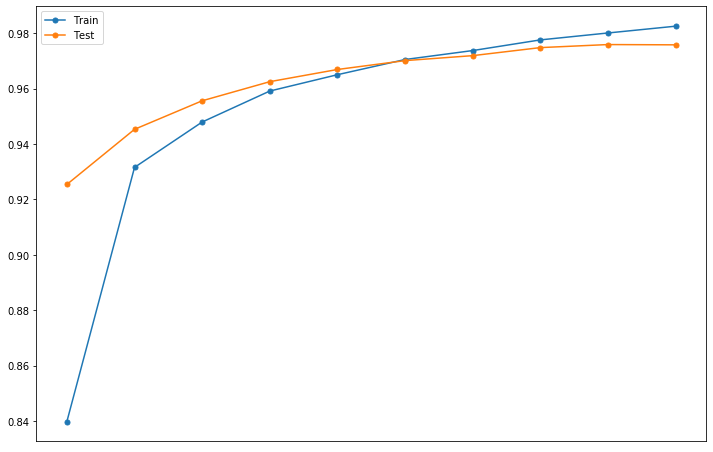

In [41]:
plotAccuracy(acc_values1, val_acc_values1)

In [42]:
predictions_train = model1.predict_classes(X_train, verbose=0)

In [43]:
confusion_matrix(t_train, predictions_train)

array([[5897,    2,    3,    0,    0,    1,    6,    1,    8,    5],
       [   1, 6704,    9,    2,    2,    1,    3,    9,    7,    4],
       [   7,    4, 5910,    4,    6,    2,    2,   12,    7,    4],
       [   5,    6,   43, 5963,    0,   45,    0,   17,   35,   17],
       [   3,   14,    8,    0, 5732,    1,    9,    5,    3,   67],
       [   7,    4,    5,   12,    4, 5349,   14,    2,   12,   12],
       [  17,    5,    2,    0,    5,    8, 5873,    0,    8,    0],
       [   2,   17,   24,    1,    9,    1,    0, 6186,    5,   20],
       [  10,   32,   10,    6,    3,   10,   13,    4, 5752,   11],
       [  10,   11,    2,   13,    7,    9,    1,   21,   13, 5862]])

In [44]:
accuracy_score(t_train, predictions_train)

0.9871333333333333

In [45]:
meas = precision_recall_fscore_support(t_train, predictions_train, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 1.00, recall= 0.99, f-measure= 0.99
Class 1: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 2: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 3: precision= 0.97, recall= 0.98, f-measure= 0.98
Class 4: precision= 0.98, recall= 0.99, f-measure= 0.99
Class 5: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 6: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 7: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 8: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 9: precision= 0.99, recall= 0.98, f-measure= 0.98


In [44]:
predictions_test = model1.predict_classes(X_test, verbose=0)

In [45]:
confusion_matrix(t_test, predictions_test)

array([[ 970,    0,    2,    2,    0,    2,    2,    1,    1,    0],
       [   0, 1121,    4,    0,    0,    1,    4,    0,    5,    0],
       [   4,    1, 1010,    1,    2,    0,    2,    6,    6,    0],
       [   0,    0,    4,  992,    0,    1,    1,    5,    3,    4],
       [   1,    0,    3,    0,  964,    0,    2,    1,    2,    9],
       [   2,    0,    0,    8,    1,  870,    5,    1,    4,    1],
       [   6,    3,    1,    1,    6,    3,  938,    0,    0,    0],
       [   1,    5,   11,    3,    1,    0,    0, 1000,    0,    7],
       [   5,    0,    4,    6,    5,    5,    4,    5,  934,    6],
       [   3,    4,    1,    6,   10,    1,    2,    8,    1,  973]])

In [46]:
accuracy_score(t_test, predictions_test)

0.9772

In [47]:
meas = precision_recall_fscore_support(t_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 0.99, recall= 0.98, f-measure= 0.98
Class 1: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 2: precision= 0.98, recall= 0.97, f-measure= 0.97
Class 3: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 4: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 5: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 6: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 7: precision= 0.97, recall= 0.97, f-measure= 0.97
Class 8: precision= 0.96, recall= 0.97, f-measure= 0.97
Class 9: precision= 0.96, recall= 0.97, f-measure= 0.97


In [48]:
w0 = model1.layers[0].get_weights()[0]
w1 = model1.layers[3].get_weights()[0]
w = np.dot(w0,w1)

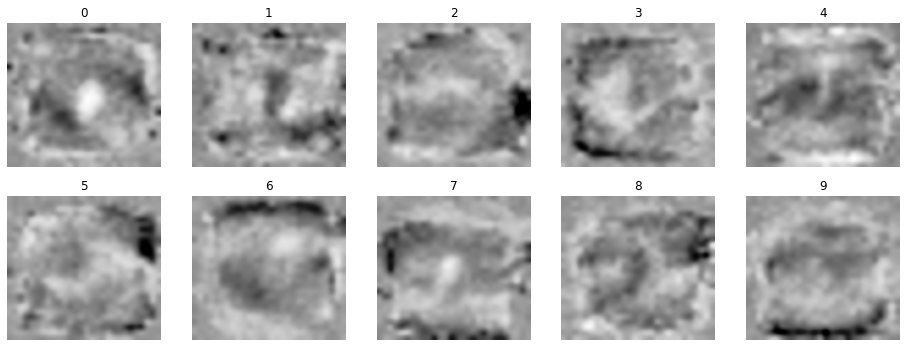

In [49]:
fig = plt.figure(figsize=(16,16))
fig.patch.set_facecolor('white')
for i in range(10):
    ax = subplot(2,5,i+1,frame_on=False, facecolor="#F8F8F8")
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    imshow(w[:,i].reshape(28,28), interpolation='quadric', 
           cmap=plt.get_cmap('Greys'), vmin=np.mean(w[:,i])-3.5*np.std(w[:,i]), 
           vmax=np.mean(w[:,i])+3.5*np.std(w[:,i]), aspect='auto')
    plt.title(i)
plt.subplots_adjust(top=0.4)
plt.show()

In [50]:
# 4 layer NN
model2 = Sequential()
model2.add(Dense(512, input_shape=(784,)))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(10))
model2.add(Activation('softmax'))

In [51]:
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [52]:
history2 = model2.fit(X_train, T_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test, T_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 105us/step - loss: 0.5049 - acc: 0.8556 - val_loss: 0.1872 - val_acc: 0.9456
Epoch 2/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.1760 - acc: 0.9481 - val_loss: 0.1243 - val_acc: 0.9620
Epoch 3/10
60000/60000 [==============================] - 6s 106us/step - loss: 0.1203 - acc: 0.9642 - val_loss: 0.0946 - val_acc: 0.9713
Epoch 4/10
60000/60000 [==============================] - 6s 103us/step - loss: 0.0897 - acc: 0.9732 - val_loss: 0.0848 - val_acc: 0.9735
Epoch 5/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.0712 - acc: 0.9790 - val_loss: 0.0719 - val_acc: 0.9777
Epoch 6/10
60000/60000 [==============================] - 6s 101us/step - loss: 0.0593 - acc: 0.9815 - val_loss: 0.0669 - val_acc: 0.9791
Epoch 7/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.0487 - acc: 0.9846 - val_loss: 0.0676 - 

In [ ]:
save_model(model2,'4MLP')

In [53]:
acc_values2 = history2.history['acc']
val_acc_values2 = history2.history['val_acc']

epochs2 = range(1, len(acc_values2) + 1)

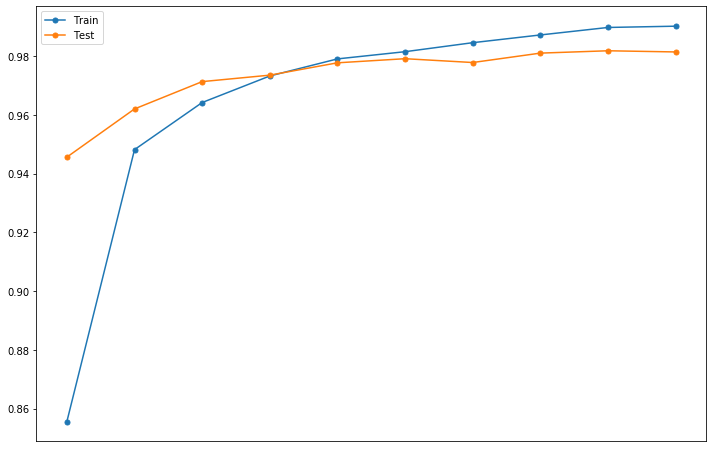

In [54]:
plotAccuracy(acc_values2, val_acc_values2)

In [55]:
predictions_train = model2.predict_classes(X_train, verbose=0)

In [56]:
confusion_matrix(t_train, predictions_train)

array([[5909,    2,    0,    0,    0,    0,    3,    0,    8,    1],
       [   1, 6737,    0,    0,    1,    0,    0,    1,    2,    0],
       [   2,    6, 5938,    2,    1,    0,    0,    3,    6,    0],
       [   0,    3,    7, 6080,    0,    6,    0,    2,   27,    6],
       [   0,    8,    0,    0, 5829,    0,    1,    1,    0,    3],
       [   0,    1,    0,    1,    0, 5407,    1,    0,    7,    4],
       [   4,    6,    1,    0,    3,    3, 5894,    0,    7,    0],
       [   0,   13,    6,    0,    1,    0,    0, 6237,    2,    6],
       [   0,    6,    1,    1,    0,    0,    0,    0, 5842,    1],
       [   0,    2,    0,    1,    8,    3,    0,    6,    6, 5923]])

In [57]:
meas = precision_recall_fscore_support(t_train, predictions_train, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 1: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 2: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 3: precision= 0.99, recall= 1.00, f-measure= 1.00
Class 4: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 5: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 6: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 7: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 8: precision= 1.00, recall= 0.99, f-measure= 0.99
Class 9: precision= 1.00, recall= 1.00, f-measure= 1.00


In [58]:
accuracy_score(t_train, predictions_train)

0.9966

In [59]:
predictions_test = model2.predict_classes(X_test, verbose=0)

In [60]:
confusion_matrix(t_test, predictions_test)

array([[ 967,    0,    0,    0,    2,    0,    2,    2,    5,    2],
       [   0, 1127,    2,    1,    0,    1,    2,    0,    2,    0],
       [   3,    2, 1009,    2,    2,    0,    2,    3,    9,    0],
       [   0,    0,    1,  992,    0,    4,    0,    3,    6,    4],
       [   1,    1,    2,    0,  967,    0,    3,    1,    1,    6],
       [   2,    0,    0,    5,    1,  873,    2,    0,    5,    4],
       [   3,    3,    1,    1,    5,    2,  938,    0,    5,    0],
       [   1,    6,    8,    2,    1,    0,    0,  999,    3,    8],
       [   0,    1,    2,    4,    4,    1,    0,    2,  957,    3],
       [   3,    5,    0,    2,    8,    1,    1,    2,    2,  985]])

In [61]:
accuracy_score(t_test, predictions_test)

0.9814

In [62]:
meas = precision_recall_fscore_support(t_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 1: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 2: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 3: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 4: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 5: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 6: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 7: precision= 0.97, recall= 0.98, f-measure= 0.98
Class 8: precision= 0.98, recall= 0.97, f-measure= 0.97
Class 9: precision= 0.98, recall= 0.97, f-measure= 0.97


In [63]:
w0 = model2.layers[0].get_weights()[0]
w1 = model2.layers[3].get_weights()[0]
w2 = model2.layers[6].get_weights()[0]
w = np.dot(np.dot(w0,w1),w2)

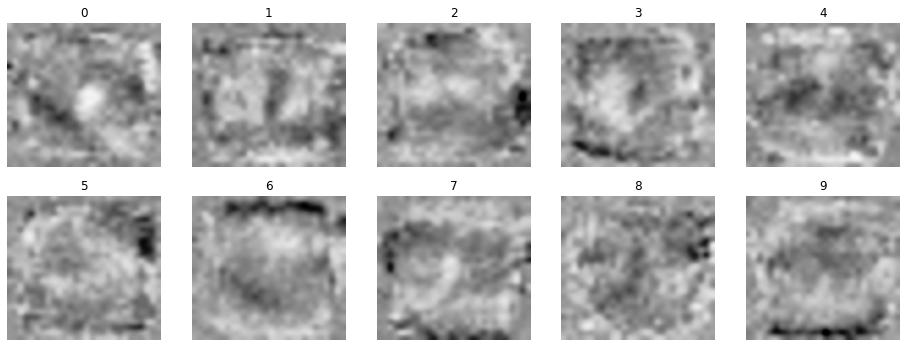

In [64]:
fig = plt.figure(figsize=(16,16))
fig.patch.set_facecolor('white')
for i in range(10):
    ax = subplot(2,5,i+1,frame_on=False, facecolor="#F8F8F8")
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    imshow(w[:,i].reshape(28,28), interpolation='quadric', 
           cmap=plt.get_cmap('Greys'), vmin=np.mean(w[:,i])-3.5*np.std(w[:,i]), 
           vmax=np.mean(w[:,i])+3.5*np.std(w[:,i]), aspect='auto')
    plt.title(i)
plt.subplots_adjust(top=0.4)
plt.show()

In [65]:
model3 = Sequential()
model3.add(Conv2D(30, (3, 3), input_shape=(1, 28, 28), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(15, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(50, activation='relu'))
model3.add(Dense(10, activation='softmax'))

In [66]:
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
X_train_c = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test_c = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

In [ ]:
#model3 = load_model('CNN')

In [69]:
history3 = model3.fit(X_train_c, T_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test_c, T_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 48s 807us/step - loss: 1.0138 - acc: 0.6915 - val_loss: 0.2682 - val_acc: 0.9218
Epoch 2/10
60000/60000 [==============================] - 55s 922us/step - loss: 0.2497 - acc: 0.9242 - val_loss: 0.1378 - val_acc: 0.9569
Epoch 3/10
60000/60000 [==============================] - 50s 840us/step - loss: 0.1522 - acc: 0.9535 - val_loss: 0.0876 - val_acc: 0.9738
Epoch 4/10
60000/60000 [==============================] - 50s 837us/step - loss: 0.1123 - acc: 0.9659 - val_loss: 0.0641 - val_acc: 0.9799
Epoch 5/10
60000/60000 [==============================] - 47s 790us/step - loss: 0.0936 - acc: 0.9711 - val_loss: 0.0555 - val_acc: 0.9819
Epoch 6/10
60000/60000 [==============================] - 47s 782us/step - loss: 0.0837 - acc: 0.9742 - val_loss: 0.0484 - val_acc: 0.9856
Epoch 7/10
60000/60000 [==============================] - 49s 822us/step - loss: 0.0735 - acc: 0.9773 - val_loss: 0.

In [70]:
save_model(model3,'CNN')

Saved model to disk


In [71]:
acc_values3 = history3.history['acc']
val_acc_values3 = history3.history['val_acc']

epochs3 = range(1, len(acc_values3) + 1)

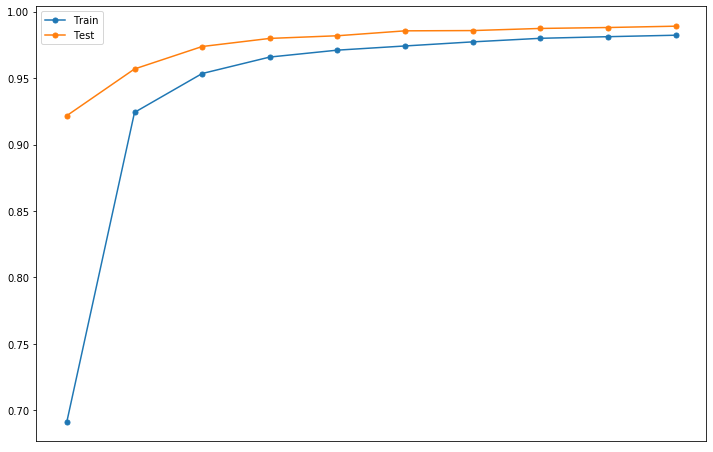

In [72]:
plotAccuracy(acc_values3, val_acc_values3)

In [73]:
predictions_train = model3.predict_classes(X_train_c, verbose=0)

In [76]:
confusion_matrix(t_train, predictions_train)

array([[5898,    2,    5,    2,    0,    0,    7,    1,    4,    4],
       [   1, 6710,    4,    0,    7,    0,    2,   14,    4,    0],
       [   7,   13, 5880,   14,    3,    1,    1,   21,   11,    7],
       [   2,    1,   13, 6068,    1,   11,    0,   15,    9,   11],
       [   1,    4,    3,    0, 5810,    0,    5,    2,    2,   15],
       [   2,    1,    1,   23,    1, 5350,   18,    2,   18,    5],
       [   4,    5,    1,    1,    8,    6, 5887,    0,    6,    0],
       [   0,   10,   10,    3,   10,    1,    0, 6219,    6,    6],
       [   6,   17,   14,    9,   17,   20,   12,    5, 5734,   17],
       [  10,    5,    0,   10,   36,   11,    2,   25,   13, 5837]])

In [77]:
accuracy_score(t_train, predictions_train)

0.9898833333333333

In [82]:
meas = precision_recall_fscore_support(t_train, predictions_train, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 1: precision= 1.00, recall= 0.99, f-measure= 0.99
Class 2: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 3: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 4: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 5: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 6: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 7: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 8: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 9: precision= 0.98, recall= 0.99, f-measure= 0.99


In [79]:
predictions_test = model3.predict_classes(X_test_c, verbose=0)

In [80]:
confusion_matrix(t_test, predictions_test)

array([[ 975,    0,    1,    0,    0,    0,    1,    1,    2,    0],
       [   0, 1130,    1,    2,    0,    0,    1,    1,    0,    0],
       [   2,    2, 1020,    0,    1,    0,    0,    6,    1,    0],
       [   0,    0,    1, 1003,    0,    2,    0,    2,    1,    1],
       [   0,    0,    0,    0,  978,    0,    0,    0,    0,    4],
       [   2,    0,    1,    5,    0,  881,    2,    1,    0,    0],
       [   3,    2,    0,    0,    3,    2,  947,    0,    1,    0],
       [   0,    3,    7,    2,    0,    0,    0, 1014,    1,    1],
       [   4,    0,    2,    2,    1,    1,    1,    4,  956,    3],
       [   1,    4,    0,    1,    8,    2,    0,    4,    2,  987]])

In [81]:
accuracy_score(t_test, predictions_test)

0.9891

In [83]:
meas = precision_recall_fscore_support(t_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 1: precision= 1.00, recall= 0.99, f-measure= 0.99
Class 2: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 3: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 4: precision= 1.00, recall= 0.99, f-measure= 0.99
Class 5: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 6: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 7: precision= 0.99, recall= 0.98, f-measure= 0.98
Class 8: precision= 0.98, recall= 0.99, f-measure= 0.99
Class 9: precision= 0.98, recall= 0.98, f-measure= 0.98
